# Parsing the entire h5ad file

## 1. Read predictions from all sources, and merge them into the AnnData object

In [1]:
import plotly.graph_objects as go, plotly.express as px
import scanpy as sc, pandas as pd, numpy as np


ANNDATA_FOLDER = 'datasets'
QUERY_DATASET_NAME = 'LCA'

# "LCA.h5ad" file is pre-annotated
predictions_adata = sc.read_h5ad(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/{QUERY_DATASET_NAME}.h5ad')
# predictions_adata.obs = pd.DataFrame(predictions_adata.obs.rename({'cell_ontology_type':'popv_preds', 'cell_type':'popv_preds'}, axis=1)['popv_preds'])


# Get rid of the individual cell-level preds from PopV. Keep only majority_voting in obs dataframe
popv_lung_preds = pd.read_csv(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/popv_preds.csv')
predictions_adata.obs['popv_preds'] = popv_lung_preds['popv_majority_vote_prediction'].tolist()
predictions_adata.obs['popv_scores'] = popv_lung_preds['popv_prediction_score'].tolist()


# Get rid of the individual cell-level preds from CellTypist. Keep only majority_voting in obs dataframe
celltypist_lung_preds = pd.read_csv(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/celltypist_preds.csv')
predictions_adata.obs['celltypist_preds'] = celltypist_lung_preds['majority_voting'].tolist()
predictions_adata.obs['celltypist_scores'] = celltypist_lung_preds['conf_score'].tolist()


# Merge in Azimuth predictions in obs dataframe
azimuth_lung_preds = pd.read_csv(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/azimuth_preds.tsv', sep=' ')
predictions_adata.obs['azimuth_preds'] = azimuth_lung_preds['predicted.ann_finest_level'].tolist()
predictions_adata.obs['azimuth_scores'] = azimuth_lung_preds['predicted.ann_finest_level.score'].tolist()




# Create new df with all unique CT-labels across 3 sources
all_cts = list(predictions_adata.obs['azimuth_preds'].to_numpy()) + \
            list(predictions_adata.obs['celltypist_preds'].to_numpy()) + \
                list(predictions_adata.obs['popv_preds'].to_numpy())
unique_cts = sorted([ct.lower().replace('φ','ï†') for ct in set(all_cts)])
unique_cts[:10]

['adventitial cell',
 'adventitial fibroblasts',
 'alveolar fibroblasts',
 'alveolar macrophages',
 'alveolar mï† ccl3+',
 'alveolar mï† proliferating',
 'at1',
 'at2',
 'at2 proliferating',
 'b cell']

In [2]:
# 1 hour to export the CxG into CSV so that we can explore FR-Match
# predictions_adata.to_df().to_csv(f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/SingleCellExperiment_src_files/cell_by_gene_expression.csv', index=False)

### 2. Create an aggregated df suggested by Katy

| unique_Cts | CT-ID | # Azimuth | # CellTypist | # PopV |
|---|---|---|---|---|

Extending this table to include Azimuth's HLCAv2 known Marker-Genes so that we can create stacked Violin-Plot.

Similarly, we can use NSForest to explore Marker-Genes so that we can create similar stacked Violin-Plots.

Final table structure:

| unique_Cts | CT-ID | # Azimuth | # CellTypist | # PopV | canonical-BGs from Azimuth | canonical-BGs from ASCTB | NSForest-BGs for Azimuth preds | NSForest-BGs for CellTypist preds | NSForest-BGs for PopV preds |
|---|---|---|---|---|---|---|---|---|---|

>

> 

>

> Future scope: Compare inter-cluster similarities by using `FR-Match`.

In [3]:
import plotly.graph_objects as go
import random


# Create a dataframe to hold information on markers pulled from Azimuth/ASCTB and NSForest.
# Later, we'll merge our crosswalk of Azimuth/CellTypist/PopV to translate labels -> ASCTB naming conventions.
agg_crosswalk_markers_df = pd.DataFrame(unique_cts, columns=['unique_cts'])


# Get aggregate count of cells per CellType label in predictions dataframe
for source in ['azimuth', 'popv', 'celltypist']:
    preds_column = f'{source}_preds'
    curr_agg_df = pd.DataFrame(predictions_adata.obs.groupby(by=[preds_column])[preds_column].count())
    curr_agg_df.columns = [f'{source}_count']
    curr_agg_df = curr_agg_df.reset_index()
    curr_agg_df[preds_column] = curr_agg_df[preds_column].str.lower().replace('φ','ï†')
    agg_crosswalk_markers_df = pd.merge(agg_crosswalk_markers_df, curr_agg_df, how='left', left_on='unique_cts', right_on=preds_column).drop([preds_column], axis=1)


agg_crosswalk_markers_df

unique_cts  azimuth_count  popv_count  \
0                         adventitial cell            NaN       417.0   
1                  adventitial fibroblasts          454.0         NaN   
2                     alveolar fibroblasts         1942.0         NaN   
3                     alveolar macrophages         9565.0         NaN   
4                       alveolar mï† ccl3+            NaN         NaN   
..                                     ...            ...         ...   
82                                    tuft            1.0         NaN   
83                       type i pneumocyte            NaN      1521.0   
84                      type ii pneumocyte            NaN      5125.0   
85  vascular associated smooth muscle cell            NaN       571.0   
86                   vein endothelial cell            NaN      1240.0   

    celltypist_count  
0                NaN  
1              592.0  
2             1847.0  
3             9004.0  
4                NaN  
..               ...  
82               NaN  
83               NaN  
84               NaN  
85               NaN  
86               NaN  

[87 rows x 4 columns]

## 3. Run NS-Forest over predicted labels to identify algorithmic marker-genes

We can then compare the marker genes that were:

> Reported by Azimuth

> Generated through a discriminatory algorithm for 1-vs-all classification (NSForest)

#### We'll maintain 2 JSON structures for:

1. Canonical markers derived from known sources (ASCTB / Azimuth)
2. Algorithmically derived markers (using NS-Forest).

The structure in general will be:

```python
{
    'Azimuth' : {
        'CellType annotation A' : [list of markers],
        'CellType annotation B' : [list of markers],
        ...
    },
    'CellTypist' : {
        'CellType annotation X' : [list of markers],
        'CellType annotation Y' : [list of markers],
        ...
    },
    
    ...
}
```

In [4]:
CANONICAL_MARKERS = {}
ALGORITHMICALLY_DERIVED_MARKERS = {}

# 4. Fetch ASCT+B marker genes

In [5]:
from utils.asctb_util_functions import get_asctb_data, parse_asctb_ct_vs_bg
from utils.crosswalk_util_functions import fetch_and_parse_crosswalk_table, get_crosswalk_translation_hmap

# Read and preprocess the Crosswalk table with SME Feedback to translate annotations -> ASCTB convention
crosswalk_df = fetch_and_parse_crosswalk_table(
    crosswalk_filename='ASCTB_Mapper/Azimuth_CellTypist_PopV_Lung_ASCTB_Crosswalks.csv',
    raw_labels_colname='raw_input_label',
    asctb_crosswalk_colname='Glorias_recco_for_ASCTB_Crosswalk',
    tgt_crosswalk_colname='asctb_equivalent',
    verbose=False
)


# Merge the crosswalk into the existing aggregate view of unique CT-labels, counts in the 3 sources and markers from various sources 
agg_crosswalk_markers_df = pd.merge(agg_crosswalk_markers_df, crosswalk_df[['raw_input_label', 'asctb_equivalent']], how='left', left_on='unique_cts', right_on='raw_input_label')
agg_crosswalk_markers_df = agg_crosswalk_markers_df.drop(columns=['raw_input_label']).drop_duplicates(subset=['unique_cts']).fillna(0).reset_index(drop=True)

translation_hmap = get_crosswalk_translation_hmap(agg_crosswalk_markers_df)



# Fetch ASCTB Lung data and merge it into our Aggregated dataframe containing counts, and crosswalk information.
response = get_asctb_data(asctb_organ='Lung', asctb_organ_version='v1.2', verbose=False)
raw_asctb_markers_json = parse_asctb_ct_vs_bg(response, verbose=False)

# Parse the json into a usable dataframe of ASCTB CT vs Markers
asctb_markers_df = pd.DataFrame([raw_asctb_markers_json]).T.reset_index()
asctb_markers_df.columns = ['asctb_label', 'asctb_markers']



if 'asctb_markers' not in agg_crosswalk_markers_df.columns:
    agg_crosswalk_markers_df = pd.merge(
        left=agg_crosswalk_markers_df,
        right=asctb_markers_df,
        left_on='asctb_equivalent',
        right_on='asctb_label'
    )
    agg_crosswalk_markers_df = agg_crosswalk_markers_df.drop('asctb_label', axis=1)



# store cluster-marker information in a dictionary
CANONICAL_MARKERS['asctb'] = dict(
    zip(
        agg_crosswalk_markers_df.loc[~agg_crosswalk_markers_df['asctb_markers'].isna(), 'unique_cts'],
        agg_crosswalk_markers_df.loc[~agg_crosswalk_markers_df['asctb_markers'].isna(), 'asctb_markers'],
    )
)

agg_crosswalk_markers_df.head()

unique_cts  azimuth_count  popv_count  celltypist_count  \
0      adventitial cell            0.0       417.0               0.0   
1            suprabasal          580.0         0.0             860.0   
2  alveolar fibroblasts         1942.0         0.0            1847.0   
3  alveolar macrophages         9565.0         0.0            9004.0   
4    alveolar mï† ccl3+            0.0         0.0               0.0   

             asctb_equivalent                                    asctb_markers  
0             suprabasal cell                [NOTCH3, KRT19, NGFR, KRT5, TP63]  
1             suprabasal cell                [NOTCH3, KRT19, NGFR, KRT5, TP63]  
2  alveolar type 1 fibroblast                     [PCDH15, WNT2, TCF21, PLIN2]  
3         alveolar macrophage   [CD163, MRC1, CD11c, FABP4, CD68, MARCO, CD45]  
4   alveolar macrophage ccl3+  [SIGLEC1, CCL3, CD206 , CD68, PTPRC/CD45, CD45]

# Next, visualize the markers identified using Scanpy Violin-Plot

## a. Let's Focus on Azimuth first:

### 1. Azimuth's canonical marker-genes pulled directly from the Azimuth-website's repository

In [6]:
sc.pp.normalize_total(predictions_adata, target_sum = 1e4)
sc.pp.log1p(predictions_adata)

In [7]:
from utils.azimuth_util_functions import get_all_azimuth_marker_genes, filter_valid_set_genes


azimuth_marker_genes_df = get_all_azimuth_marker_genes(organ='lung', verbose=False)
azimuth_marker_genes_df['azimuth_markers'] = azimuth_marker_genes_df['azimuth_markers'].apply(
    filter_valid_set_genes, 
    genes_available_in_anndata=set(predictions_adata.var_names),
    verbose=False
)


agg_crosswalk_markers_df = pd.merge(agg_crosswalk_markers_df, azimuth_marker_genes_df, how='left', on='unique_cts').drop_duplicates(subset=['unique_cts'])
agg_crosswalk_markers_df.head()

unique_cts  azimuth_count  popv_count  celltypist_count  \
0      adventitial cell            0.0       417.0               0.0   
1            suprabasal          580.0         0.0             860.0   
2  alveolar fibroblasts         1942.0         0.0            1847.0   
3  alveolar macrophages         9565.0         0.0            9004.0   
4    alveolar mï† ccl3+            0.0         0.0               0.0   

             asctb_equivalent  \
0             suprabasal cell   
1             suprabasal cell   
2  alveolar type 1 fibroblast   
3         alveolar macrophage   
4   alveolar macrophage ccl3+   

                                     asctb_markers  \
0                [NOTCH3, KRT19, NGFR, KRT5, TP63]   
1                [NOTCH3, KRT19, NGFR, KRT5, TP63]   
2                     [PCDH15, WNT2, TCF21, PLIN2]   
3   [CD163, MRC1, CD11c, FABP4, CD68, MARCO, CD45]   
4  [SIGLEC1, CCL3, CD206 , CD68, PTPRC/CD45, CD45]   

                                     azimuth_markers  
0                                                NaN  
1  [LDHB, KRT17, PRDX2, KRT19, SFN, S100A2, SERPI...  
2  [ADH1B, COL1A2, LUM, GPX3, C1R, MFAP4, C1S, CO...  
3  [CTSS, C1QC, ACP5, HLA-DPB1, FCER1G, COTL1, HL...  
4                                                NaN

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: AT1, AT2, AT2 proliferating, etc.
var_group_labels: suprabasal, alveolar fibroblasts, alveolar macrophages, etc.


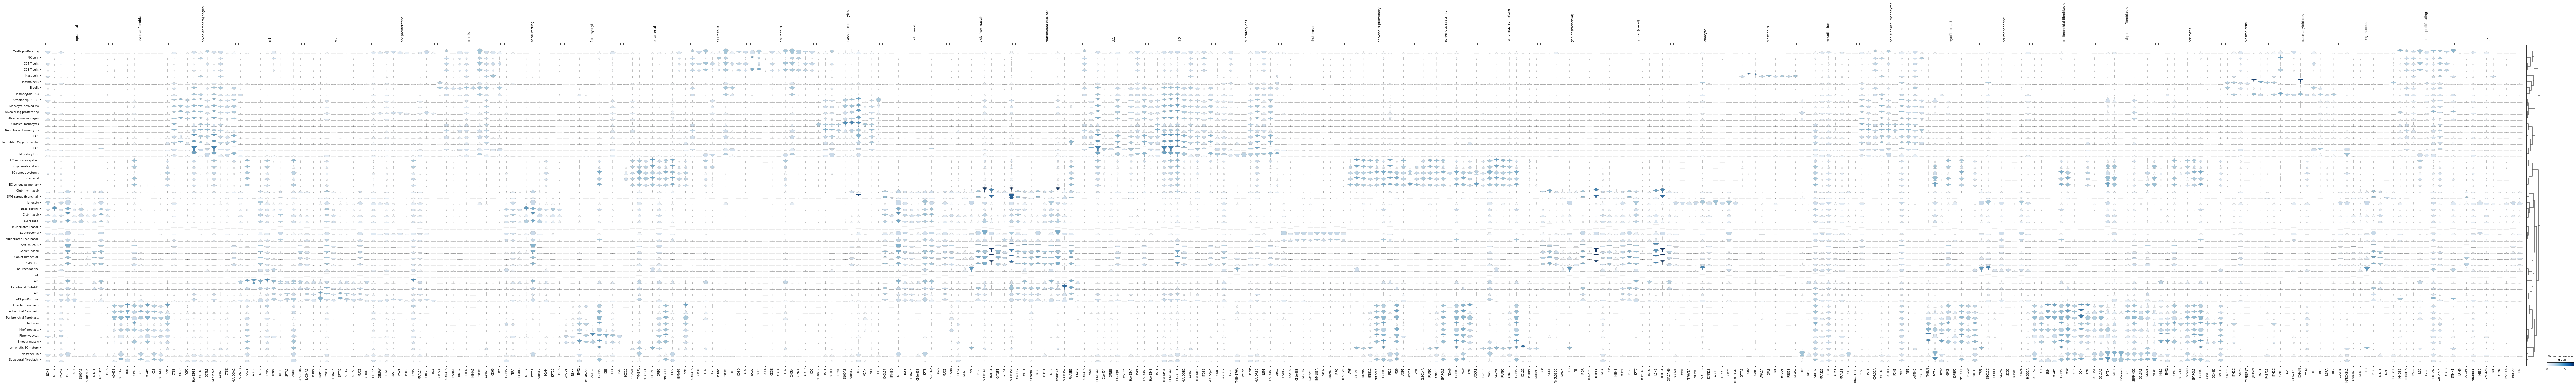

In [8]:
# store cluster-marker information in a dictionary
CANONICAL_MARKERS['azimuth'] = dict(
    zip(
        agg_crosswalk_markers_df.loc[~agg_crosswalk_markers_df['azimuth_markers'].isna(), 'unique_cts'],
        agg_crosswalk_markers_df.loc[~agg_crosswalk_markers_df['azimuth_markers'].isna(), 'azimuth_markers'],
    )
)

sc.pl.stacked_violin(
    predictions_adata, 
    var_names=CANONICAL_MARKERS['azimuth'], 
    groupby='azimuth_preds', 
    dendrogram=True, 
    use_raw=False
)

categories: AT1, AT2, AT2 proliferating, etc.
var_group_labels: suprabasal, alveolar fibroblasts, alveolar macrophages, etc.


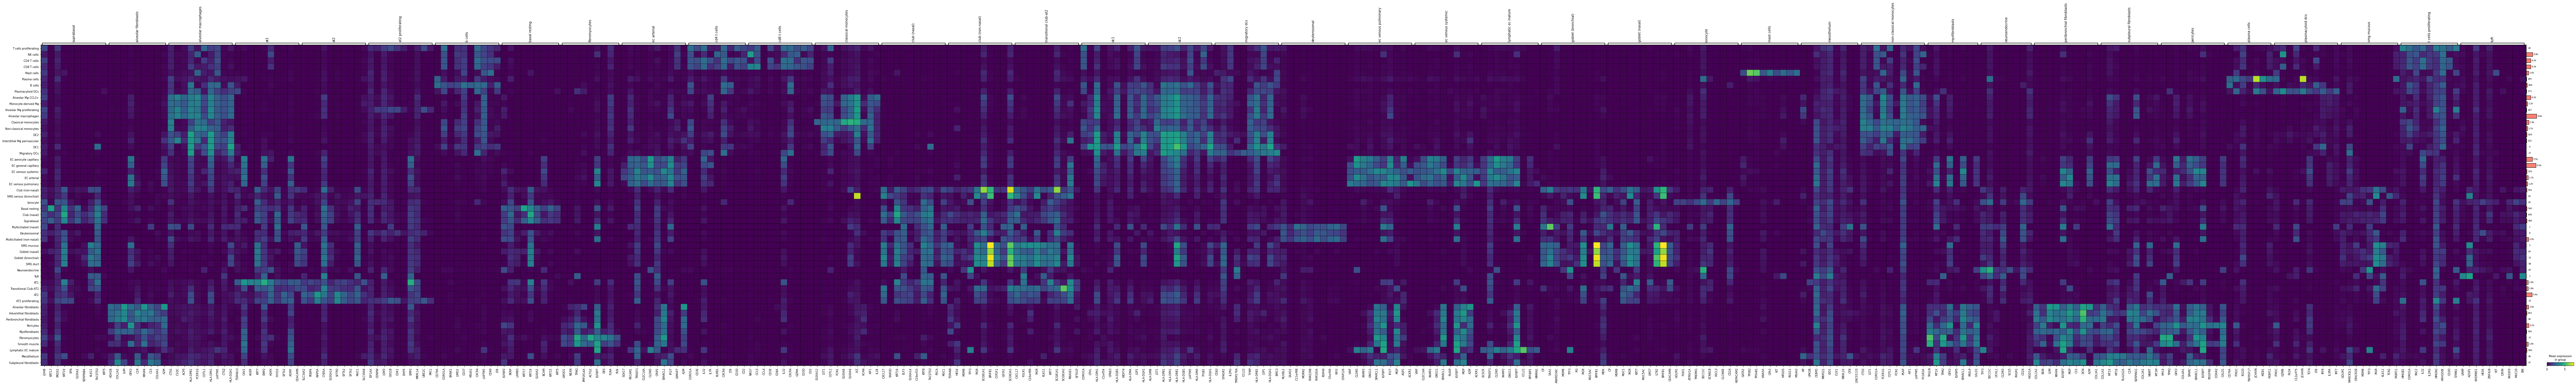

In [9]:
fig = sc.pl.matrixplot(
    predictions_adata, 
    var_names=CANONICAL_MARKERS['azimuth'],
    groupby='azimuth_preds',
    dendrogram=True,
    return_fig=True)
fig.add_totals().style(edge_color='black', edge_lw=0.5)
fig.show()

### 2. NSForest's computed marker-genes for Azimuth's HLCA-Finest predictions

In [10]:
from ns_forest.NSForest_v3dot9_1 import NSForest
from ast import literal_eval
import os

# Which column of CT-annotations do you want to analyze?
ANNOTATION_SOURCE_NAME = 'azimuth'
ANNOTATION_COLUMN_NAME = f'{ANNOTATION_SOURCE_NAME}_preds'

ns_forest_markers_filename = f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/NSForest_{ANNOTATION_SOURCE_NAME}_markers.csv'
print(f'Checking if NS-Forest has already been executed...')
try:
    ns_forest_markers_df = pd.read_csv(ns_forest_markers_filename)
    if ns_forest_markers_df['NSForest_markers'].dtype == 'object':
        ns_forest_markers_df.loc[:, 'NSForest_markers'] = [literal_eval(s) for s in ns_forest_markers_df['NSForest_markers'].values]
    print(f'Found pre-computed NS-Forest markers at {ns_forest_markers_filename}...')
except Exception as e:
    print(f'Something went wrong while trying to read {ns_forest_markers_filename}. Are you sure it exists? {e}')
    print(f'Running NSForest over entire AnnData containing {predictions_adata.obs[ANNOTATION_COLUMN_NAME].nunique()} labels...')
    ns_forest_markers_df = NSForest( 
        adata=predictions_adata,  cluster_header=ANNOTATION_COLUMN_NAME,
        # n_trees = 10, n_genes_eval = 10,  cluster_list = ["AT2"]
    )
    ns_forest_markers_df.to_csv(ns_forest_markers_filename, index=False)
    
    
ns_forest_markers_df.head()

Checking if NS-Forest has already been executed...
Found pre-computed NS-Forest markers at datasets/LCA/NSForest_azimuth_markers.csv...


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


clusterName   f_score       PPV     TN   FP    FN    TP  \
0                      AT1  0.842184  0.919384  73372   89   595  1015   
1                      AT2  0.953690  0.977507  69613  107   701  4650   
2        AT2 proliferating  0.932203  1.000000  75056    0     4    11   
3  Adventitial fibroblasts  0.838926  0.965251  74608    9   204   250   
4        Alveolar Mφ CCL3+  0.755748  0.782766  70065  779  1420  2807   

   marker_count   NSForest_markers  \
0             1             [AGER]   
1             2       [PGC, NAPSA]   
2             3  [PGC, TK1, KIF23]   
3             2      [SFRP2, PI16]   
4             2     [CXCL5, TNIP3]   

                                        binary_genes  
0  ['AGER', 'SCEL', 'TNNC1', 'RTKN2', 'UPK3B', 'C...  
1  ['ABCA3', 'PGC', 'LRRK2', 'PLA2G1B', 'CLDN18',...  
2  ['YBX2', 'PEG10', 'PGC', 'TK1', 'KIF23', 'NAPS...  
3  ['SFRP2', 'MFAP5', 'PI16', 'SCARA5', 'SFRP4', ...  
4  ['CXCL5', 'TNFAIP6', 'IL1B', 'ITGB8', 'LILRA4'...

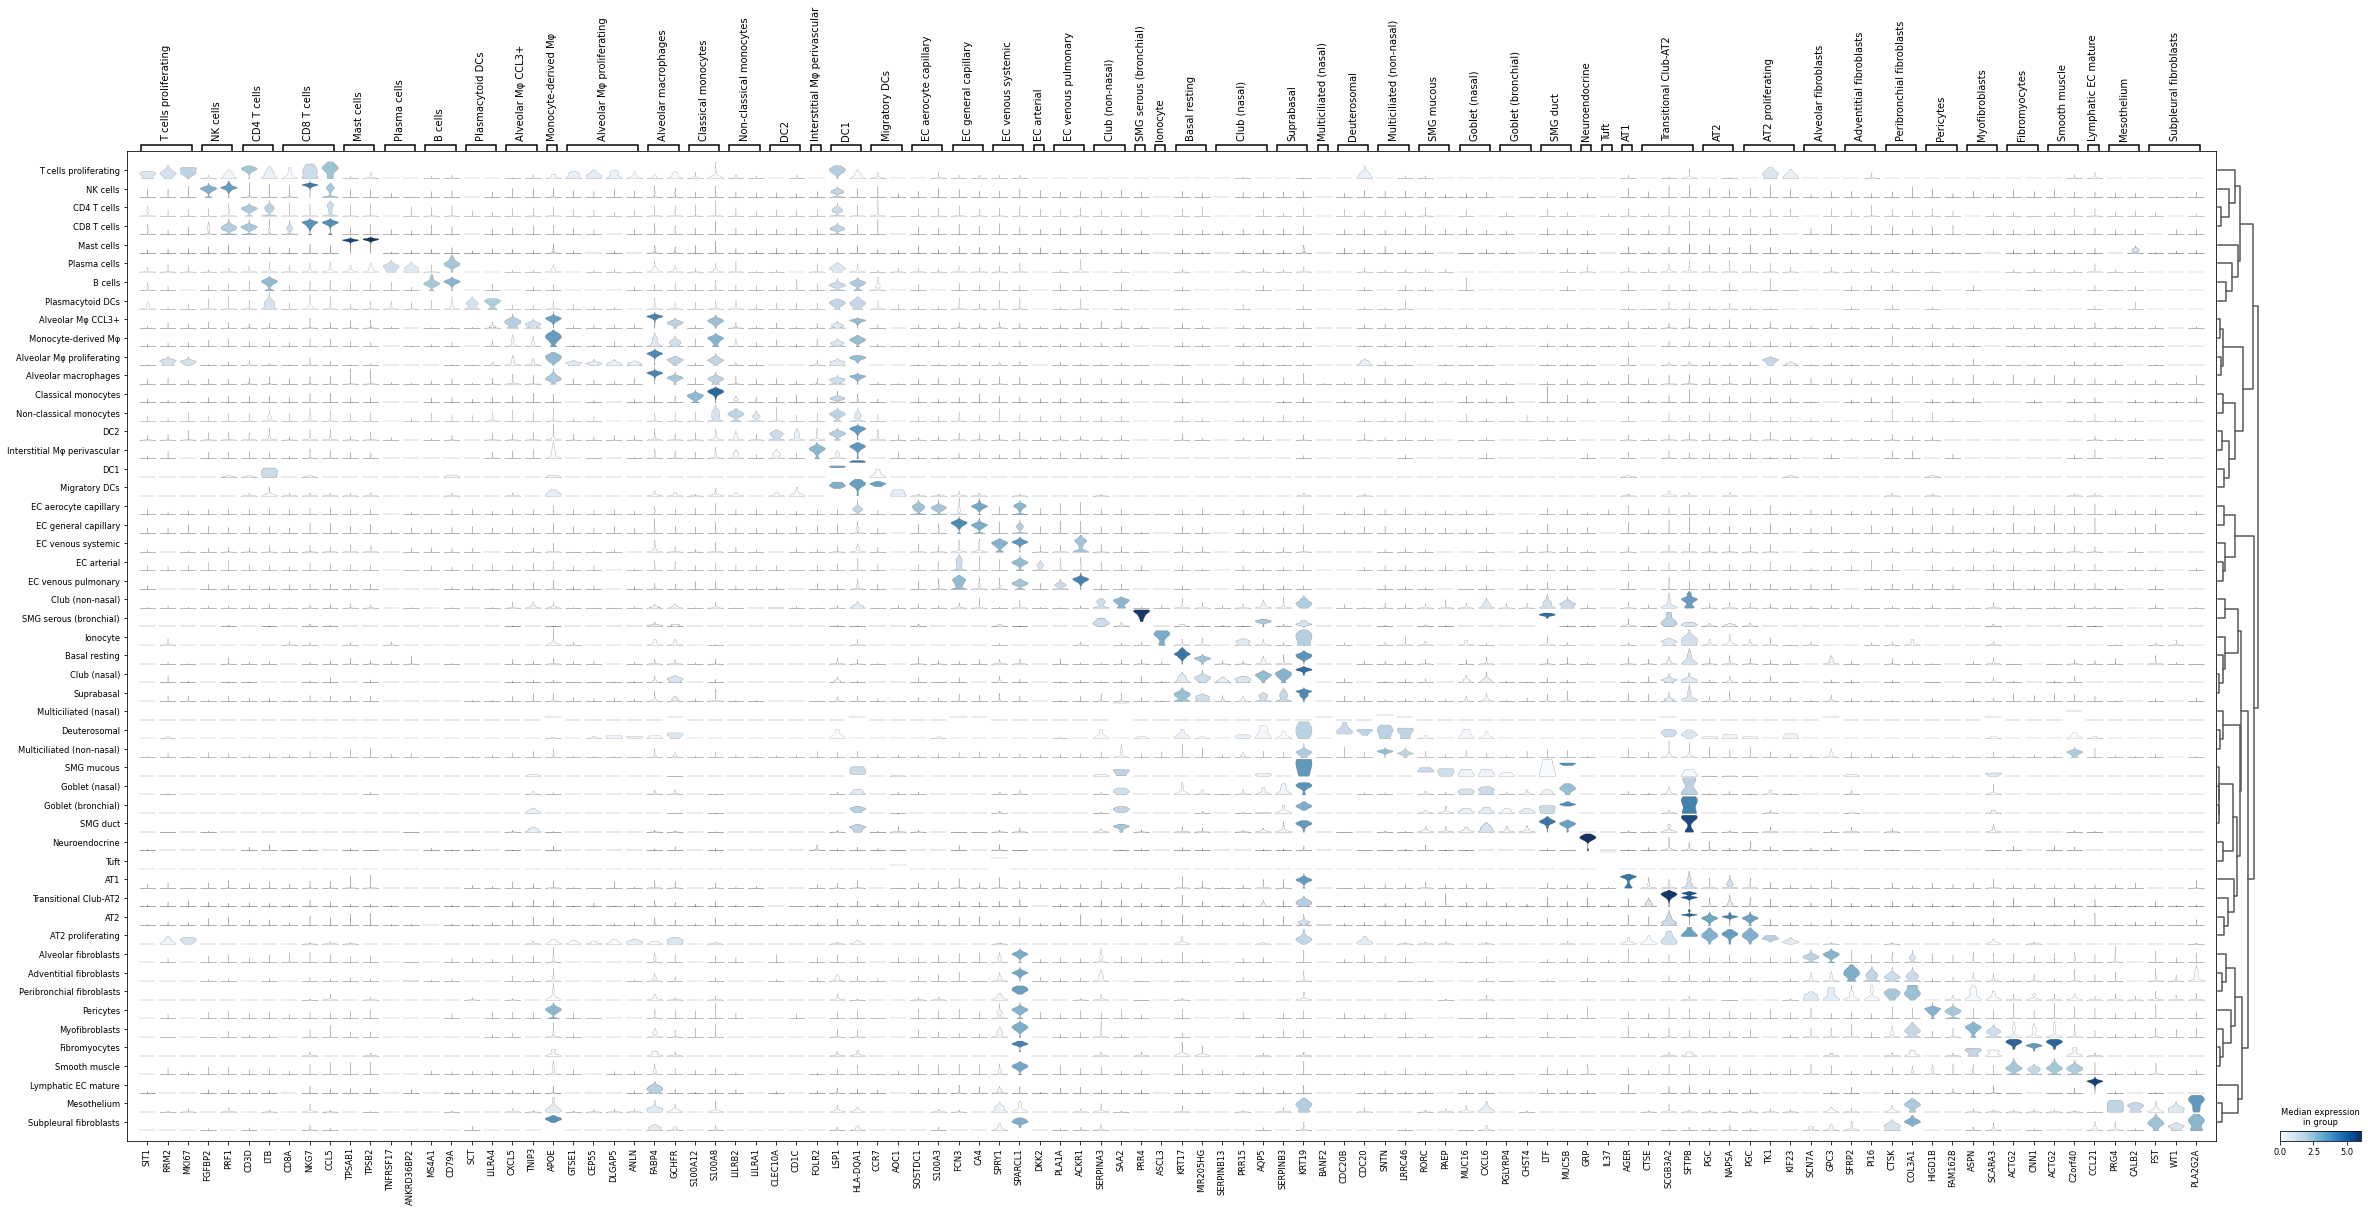

In [11]:
ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME] = dict(
    zip(
        ns_forest_markers_df['clusterName'], 
        ns_forest_markers_df['NSForest_markers']
    )
)

sc.pl.stacked_violin(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    use_raw=False
)

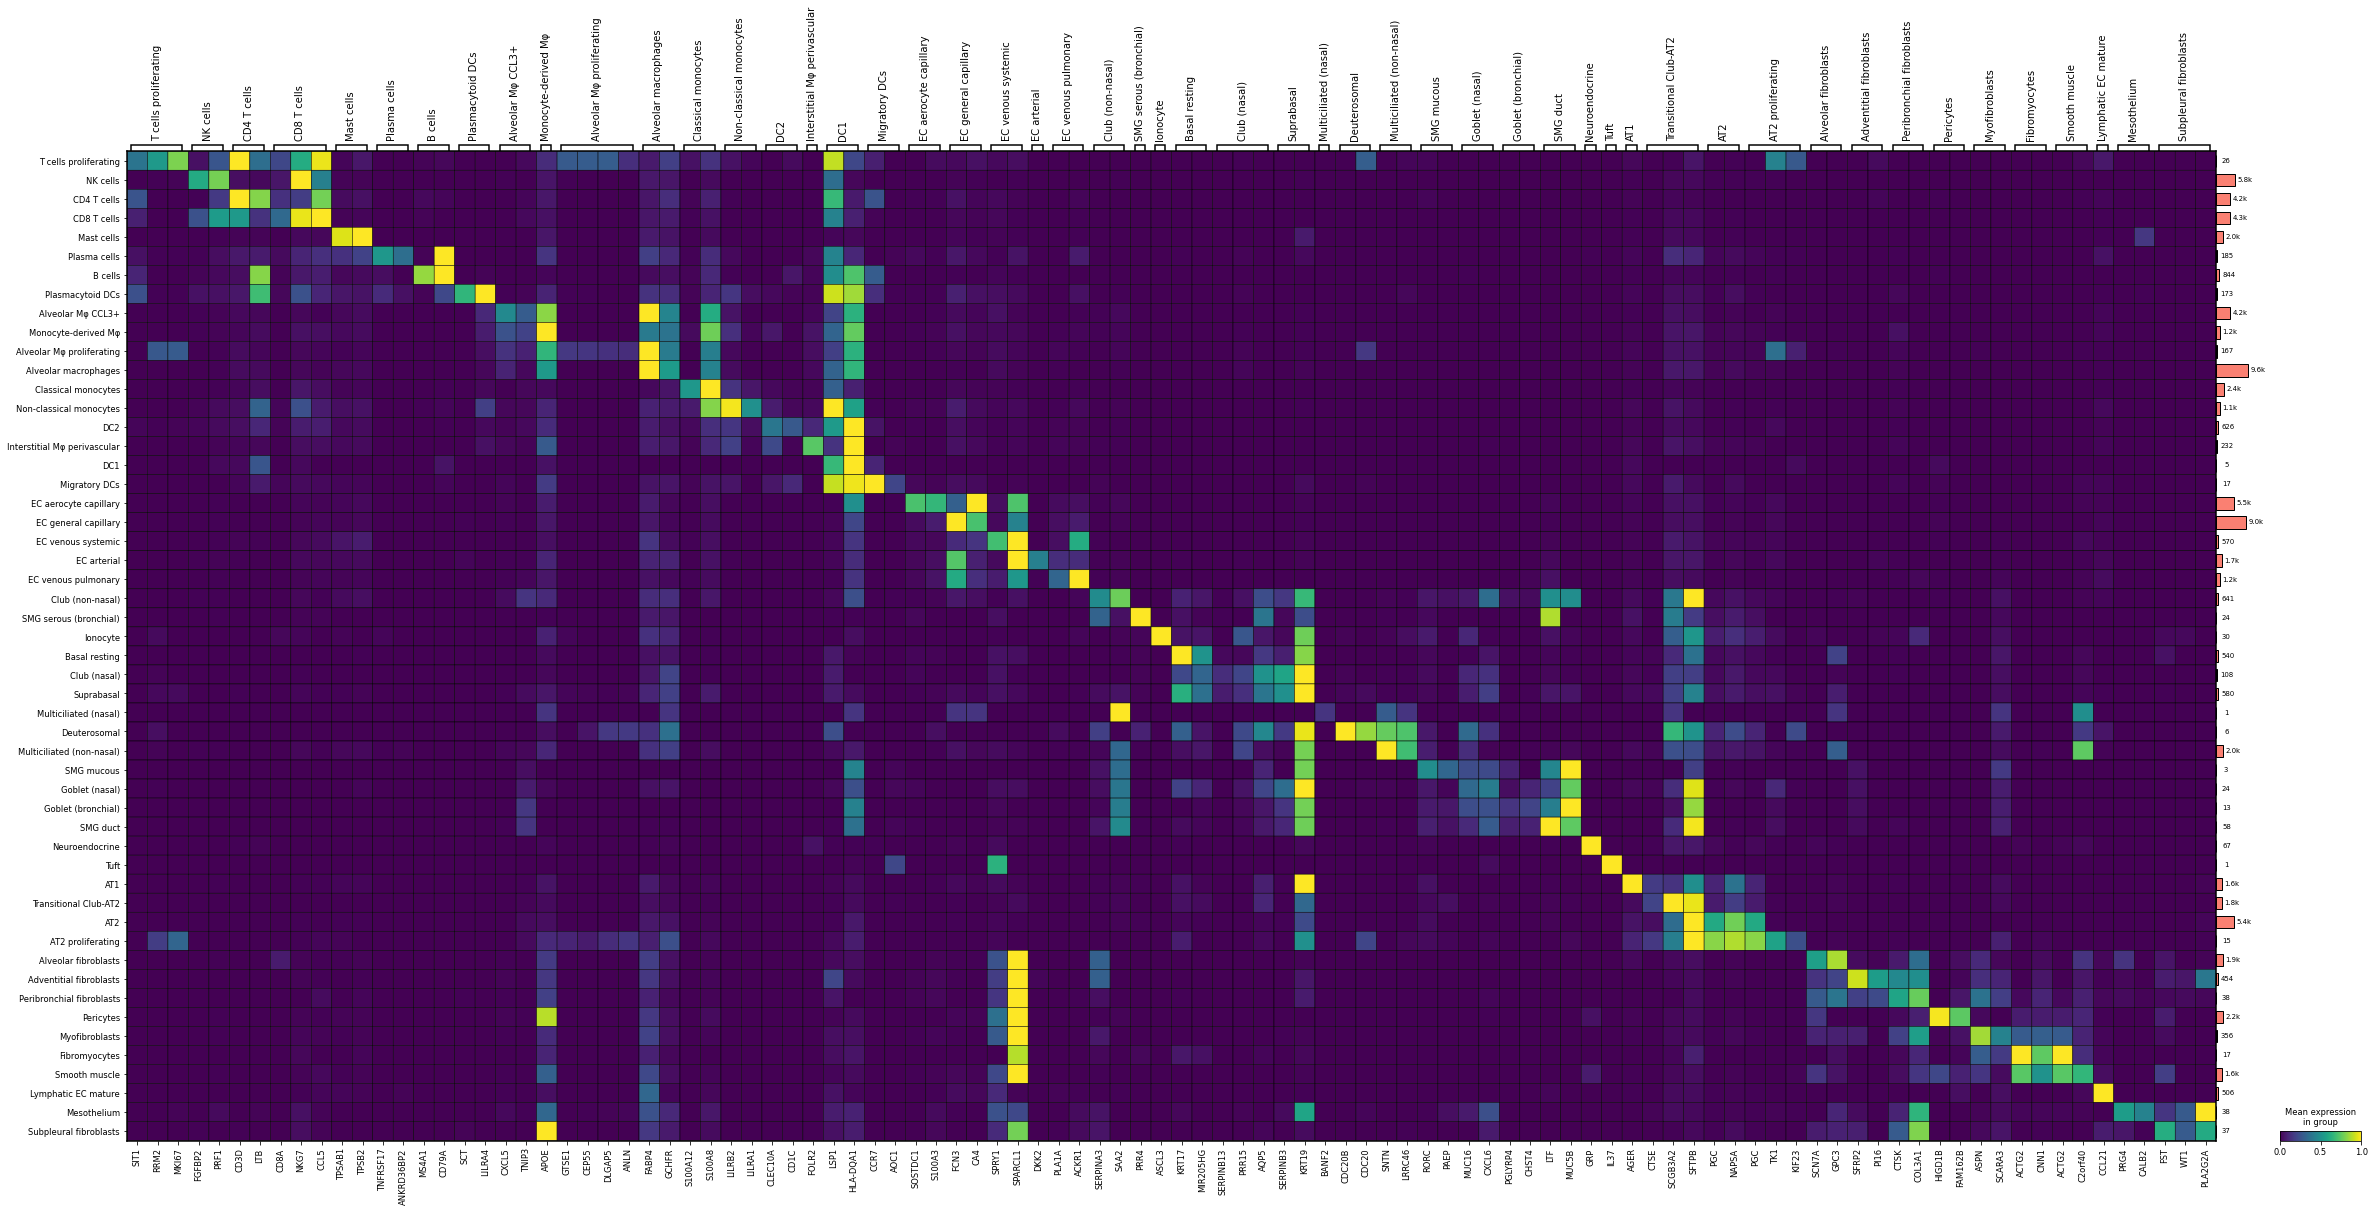

In [12]:
fig = sc.pl.matrixplot(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    return_fig=True, 
    standard_scale='group')
fig.add_totals().style(edge_color='black', edge_lw=0.5)
fig.show()

## b. Now, onto CellTypist annotations and corresponding NSForest markers:

In [13]:
from ns_forest.NSForest_v3dot9_1 import NSForest
from ast import literal_eval
import os

# Which column of CT-annotations do you want to analyze?
ANNOTATION_SOURCE_NAME = 'celltypist'
ANNOTATION_COLUMN_NAME = f'{ANNOTATION_SOURCE_NAME}_preds'

ns_forest_markers_filename = f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/NSForest_{ANNOTATION_SOURCE_NAME}_markers.csv'
print(f'Checking if NS-Forest has already been executed...')
try:
    ns_forest_markers_df = pd.read_csv(ns_forest_markers_filename)
    if ns_forest_markers_df['NSForest_markers'].dtype == 'object':
        ns_forest_markers_df.loc[:, 'NSForest_markers'] = [literal_eval(s) for s in ns_forest_markers_df['NSForest_markers'].values]
    print(f'Found pre-computed NS-Forest markers at {ns_forest_markers_filename}...')
except Exception as e:
    print(f'Something went wrong while trying to read {ns_forest_markers_filename}. Are you sure it exists? {e}')
    print(f'Running NSForest over entire AnnData containing {predictions_adata.obs[ANNOTATION_COLUMN_NAME].nunique()} labels...')
    ns_forest_markers_df = NSForest( 
        adata=predictions_adata,  cluster_header=ANNOTATION_COLUMN_NAME,
        # n_trees = 10, n_genes_eval = 10,  cluster_list = ["AT2"]
    )
    ns_forest_markers_df.to_csv(ns_forest_markers_filename, index=False)
    
    
ns_forest_markers_df.head()

Checking if NS-Forest has already been executed...
Found pre-computed NS-Forest markers at datasets/LCA/NSForest_celltypist_markers.csv...


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


clusterName   f_score       PPV     TN   FP    FN    TP  \
0                      AT1  0.865108  0.943574  73626   54   488   903   
1                      AT2  0.947963  0.974979  69565  118   790  4598   
2        AT2 proliferating  0.984848  1.000000  75057    0     1    13   
3  Adventitial fibroblasts  0.817522  0.976667  74472    7   299   293   
4        Alveolar Mφ CCL3+  0.847982  0.937550  69162  232  2194  3483   

   marker_count   NSForest_markers  \
0             1             [AGER]   
1             2      [PGC, SFTPA1]   
2             3  [PRC1, PGC, HMMR]   
3             2    [SFRP2, IGFBP6]   
4             2     [CXCL5, TNIP3]   

                                        binary_genes  
0  ['AGER', 'SCEL', 'TNNC1', 'RTKN2', 'UPK3B', 'C...  
1  ['ABCA3', 'LRRK2', 'LAMP3', 'PGC', 'PLA2G1B', ...  
2  ['YBX2', 'SFN', 'KIF23', 'PRC1', 'PGC', 'HMMR'...  
3  ['SFRP2', 'MFAP5', 'SFRP4', 'PI16', 'PDGFRL', ...  
4  ['TNFAIP6', 'CXCL5', 'TNIP3', 'IL1B', 'ITGB8',...

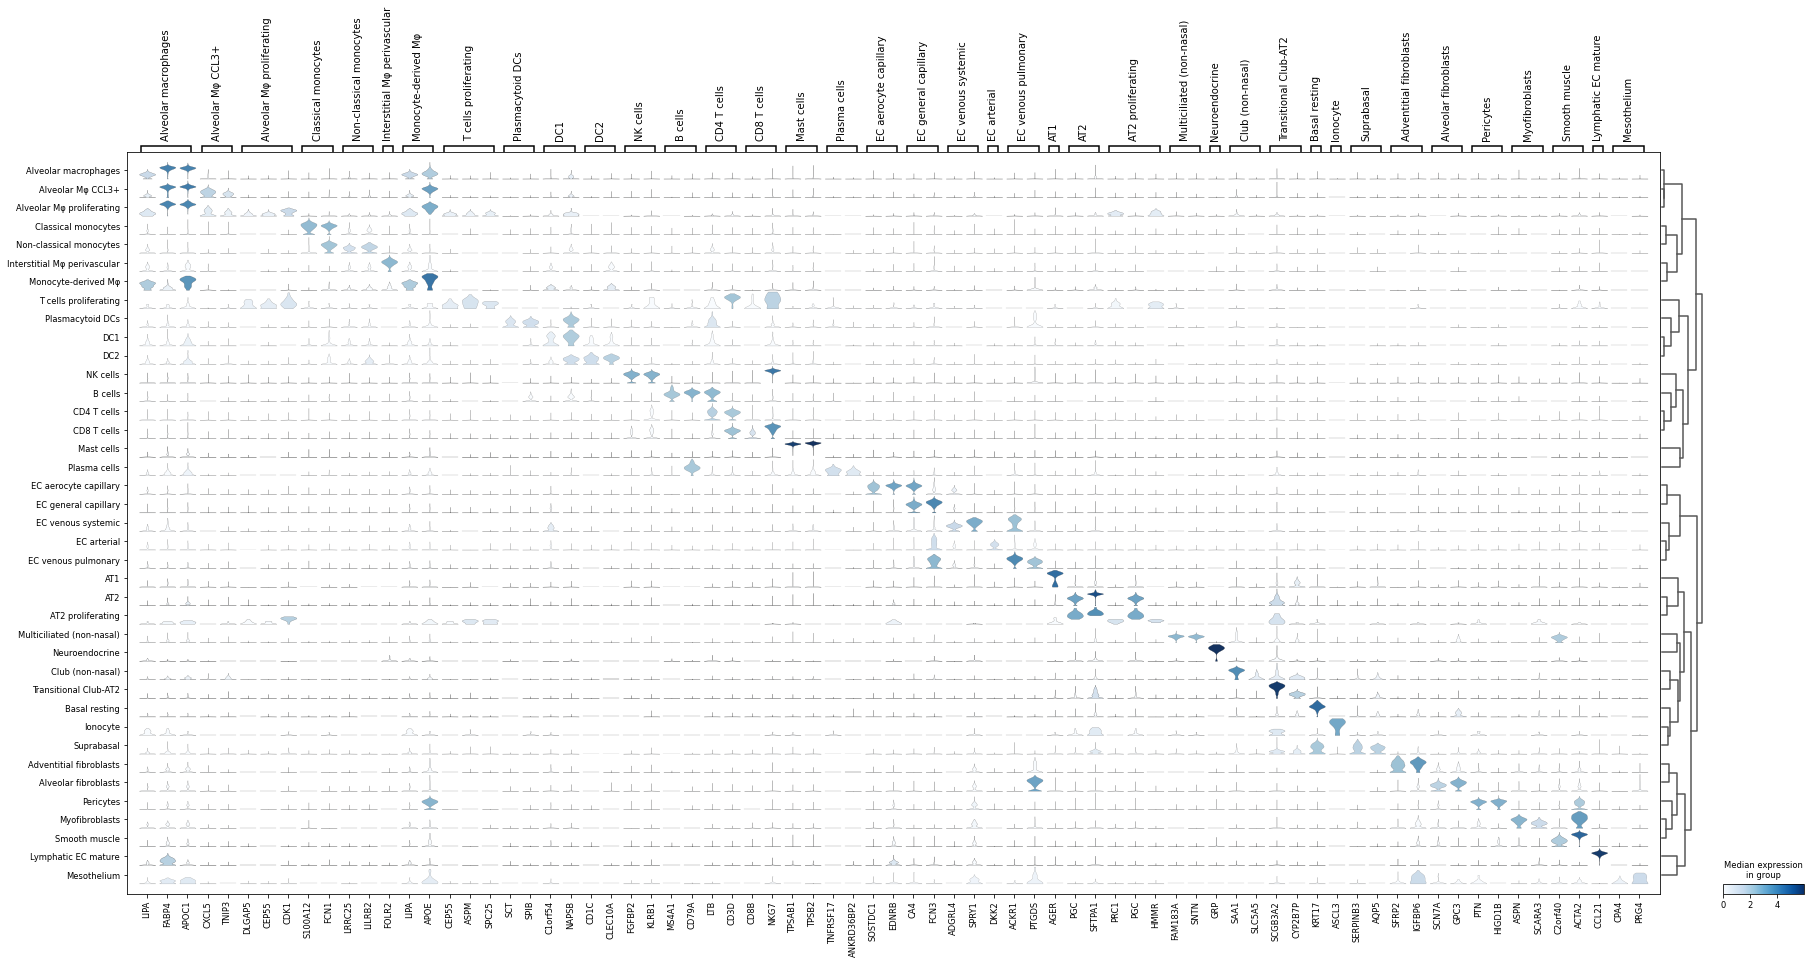

In [14]:
ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME] = dict(
    zip(
        ns_forest_markers_df['clusterName'], 
        ns_forest_markers_df['NSForest_markers']
    )
)

sc.pl.stacked_violin(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    use_raw=False
)

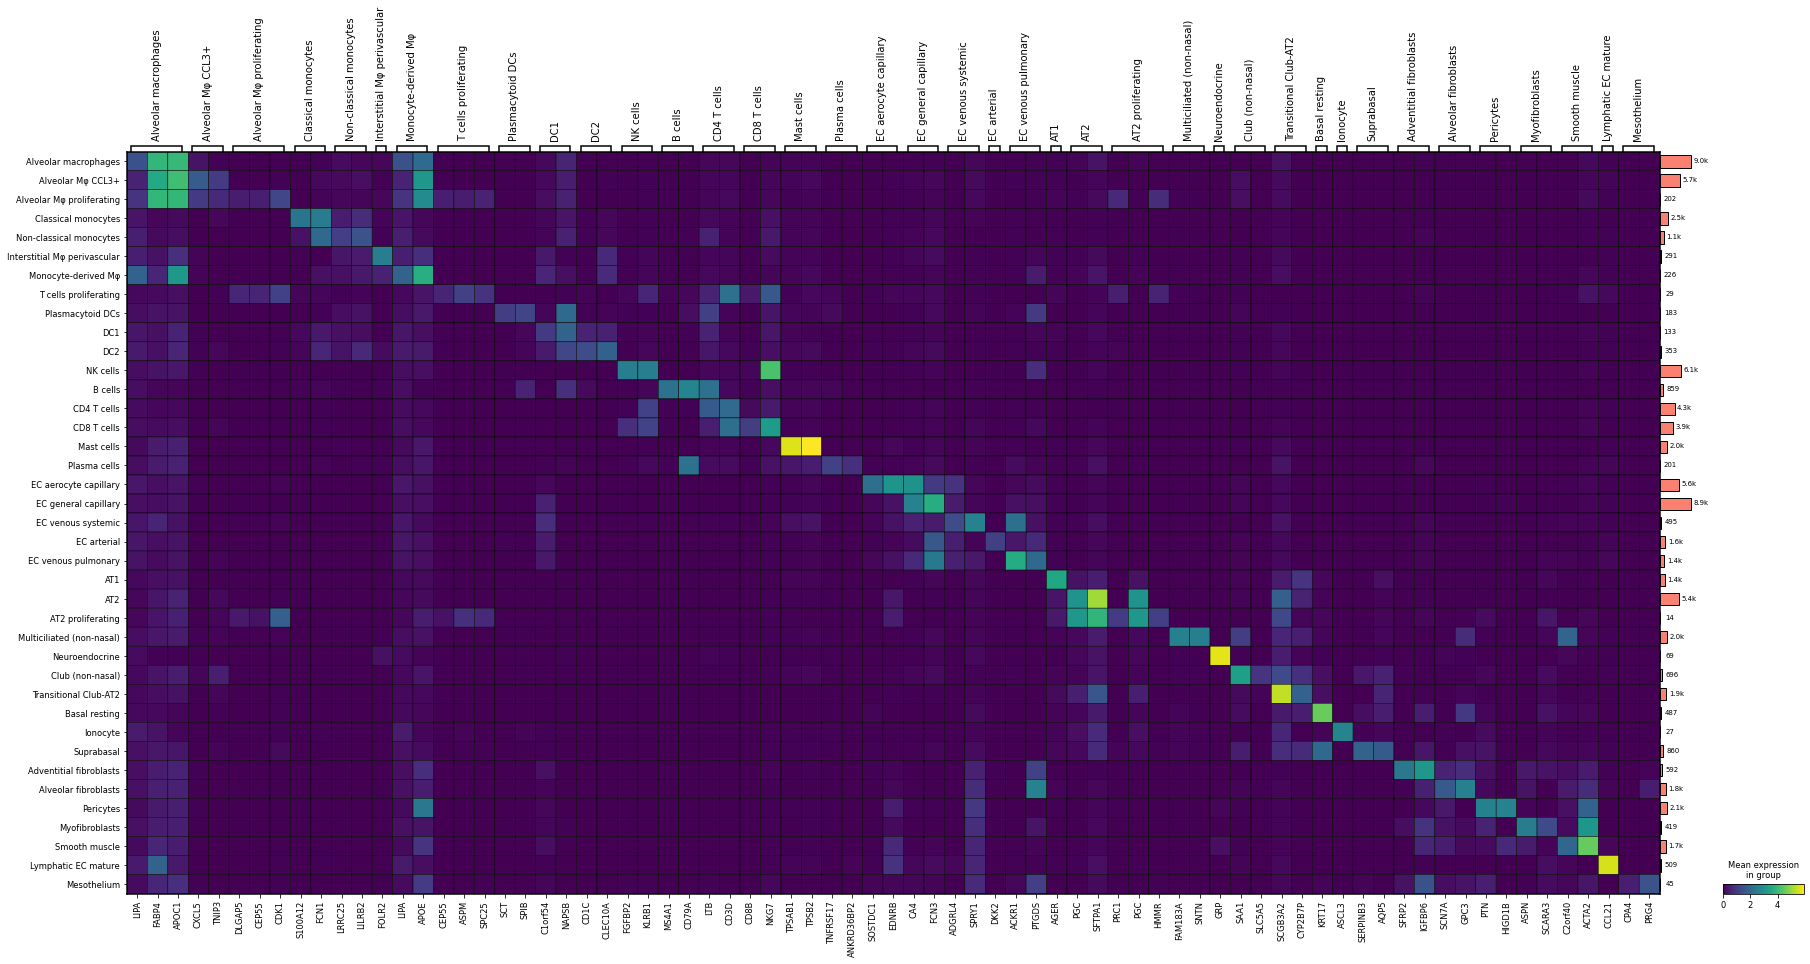

In [15]:
fig = sc.pl.matrixplot(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    return_fig=True
)
fig.add_totals().style(edge_color='black', edge_lw=0.5)
fig.show()

## c. Next, onto PopV annotations and corresponding NSForest markers:

(33 hours on Vikrant's local machine for the LCA dataset with PopV annotations)

In [17]:
# Why wasn't 'intermediate monocyte' analyzed during the NSForest execution?
# Seems there weren't many positive gene expressions in the n_top_genes. Increased the candidates to be 20.
ANNOTATION_SOURCE_NAME = 'popv'
ANNOTATION_COLUMN_NAME = f'{ANNOTATION_SOURCE_NAME}_preds'

ns_forest_markers_filename = f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/NSForest_{ANNOTATION_SOURCE_NAME}_markers.csv'


ns_forest_markers_df = NSForest( 
        adata=predictions_adata,  cluster_header=ANNOTATION_COLUMN_NAME,
#         n_trees = 10, n_genes_eval = 10,  
    n_top_genes=20,
    cluster_list = ["intermediate monocyte"]
    )

Preparing data...
--- 0.015186548233032227 seconds ---
Calculating medians...
--- 199.13488221168518 seconds ---
Number of clusters to evaluate: 1
1 out of 1:
	intermediate monocyte
	Only 1 out of 20 top Random Forest features with median > 0 will be further evaluated.
df_pred=       C6orf48
0            0
1            0
2            0
3            0
4            0
...        ...
75066        0
75067        0
75068        0
75069        0
75070        0

[75071 rows x 1 columns]
	['C6orf48']
	0.008077544426494346
--- 821.5655314922333 seconds ---


In [50]:
from ns_forest.NSForest_v3dot9_1 import NSForest
from ast import literal_eval
import os

# Which column of CT-annotations do you want to analyze?
ANNOTATION_SOURCE_NAME = 'popv'
ANNOTATION_COLUMN_NAME = f'{ANNOTATION_SOURCE_NAME}_preds'

ns_forest_markers_filename = f'{ANNDATA_FOLDER}/{QUERY_DATASET_NAME}/NSForest_{ANNOTATION_SOURCE_NAME}_markers.csv'
print(f'Checking if NS-Forest has already been executed...')
try:
    ns_forest_markers_df = pd.read_csv(ns_forest_markers_filename)
    if ns_forest_markers_df['NSForest_markers'].dtype == 'object':
        ns_forest_markers_df.loc[:, 'NSForest_markers'] = [literal_eval(s) for s in ns_forest_markers_df['NSForest_markers'].values]
    print(f'Found pre-computed NS-Forest markers at {ns_forest_markers_filename}...')
except Exception as e:
    print(f'Something went wrong while trying to read {ns_forest_markers_filename}. Are you sure it exists? {e}')
    print(f'Running NSForest over entire AnnData containing {predictions_adata.obs[ANNOTATION_COLUMN_NAME].nunique()} labels...')
    ns_forest_markers_df = NSForest( 
        adata=predictions_adata,  cluster_header=ANNOTATION_COLUMN_NAME,
        # n_trees = 10, n_genes_eval = 10,  cluster_list = ["AT2"]
    )
    ns_forest_markers_df.to_csv(ns_forest_markers_filename, index=False)
    
    
ns_forest_markers_df.head()

Checking if NS-Forest has already been executed...
Found pre-computed NS-Forest markers at datasets/LCA/NSForest_popv_markers.csv...


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


clusterName   f_score       PPV     TN    FP    FN  \
0                           B cell  0.294295  0.316045  73804   422   650   
1  CD4-positive, alpha-beta T cell  0.146251  0.132571  64787  6373  2937   
2  CD8-positive, alpha-beta T cell  0.224395  0.282176  68276  1623  4534   
3                 adventitial cell  0.055659  0.060000  74372   282   399   
4                       basal cell  0.181438  0.163453  72011  1909   778   

    TP  marker_count              NSForest_markers  \
0  195             4    [CCL20, CXCL5, IL1B, KYNU]   
1  974             3  [HLA-DQA2, TYROBP, HLA-DPB1]   
2  638             2                [HLA-E, ITM2B]   
3   18             3           [TUBB, SRGN, RPS26]   
4  373             3          [CCL5, NKG7, RPS4Y1]   

                                        binary_genes  
0  ['TNFAIP6', 'TNIP3', 'CCL20', 'CXCL5', 'IL1B',...  
1  ['HLA-DQA2', 'HLA-DRB6', 'TYROBP', 'HLA-DPA1',...  
2  ['HLA-DPA1', 'HLA-E', 'ITM2B', 'HLA-C', 'B2M',...  
3         ['IFI27', 'TUBB', 'SRGN', 'RPS26', 'PFN1']  
4  ['CCL5', 'PTPRCAP', 'NKG7', 'GZMB', 'CMC1', 'R...

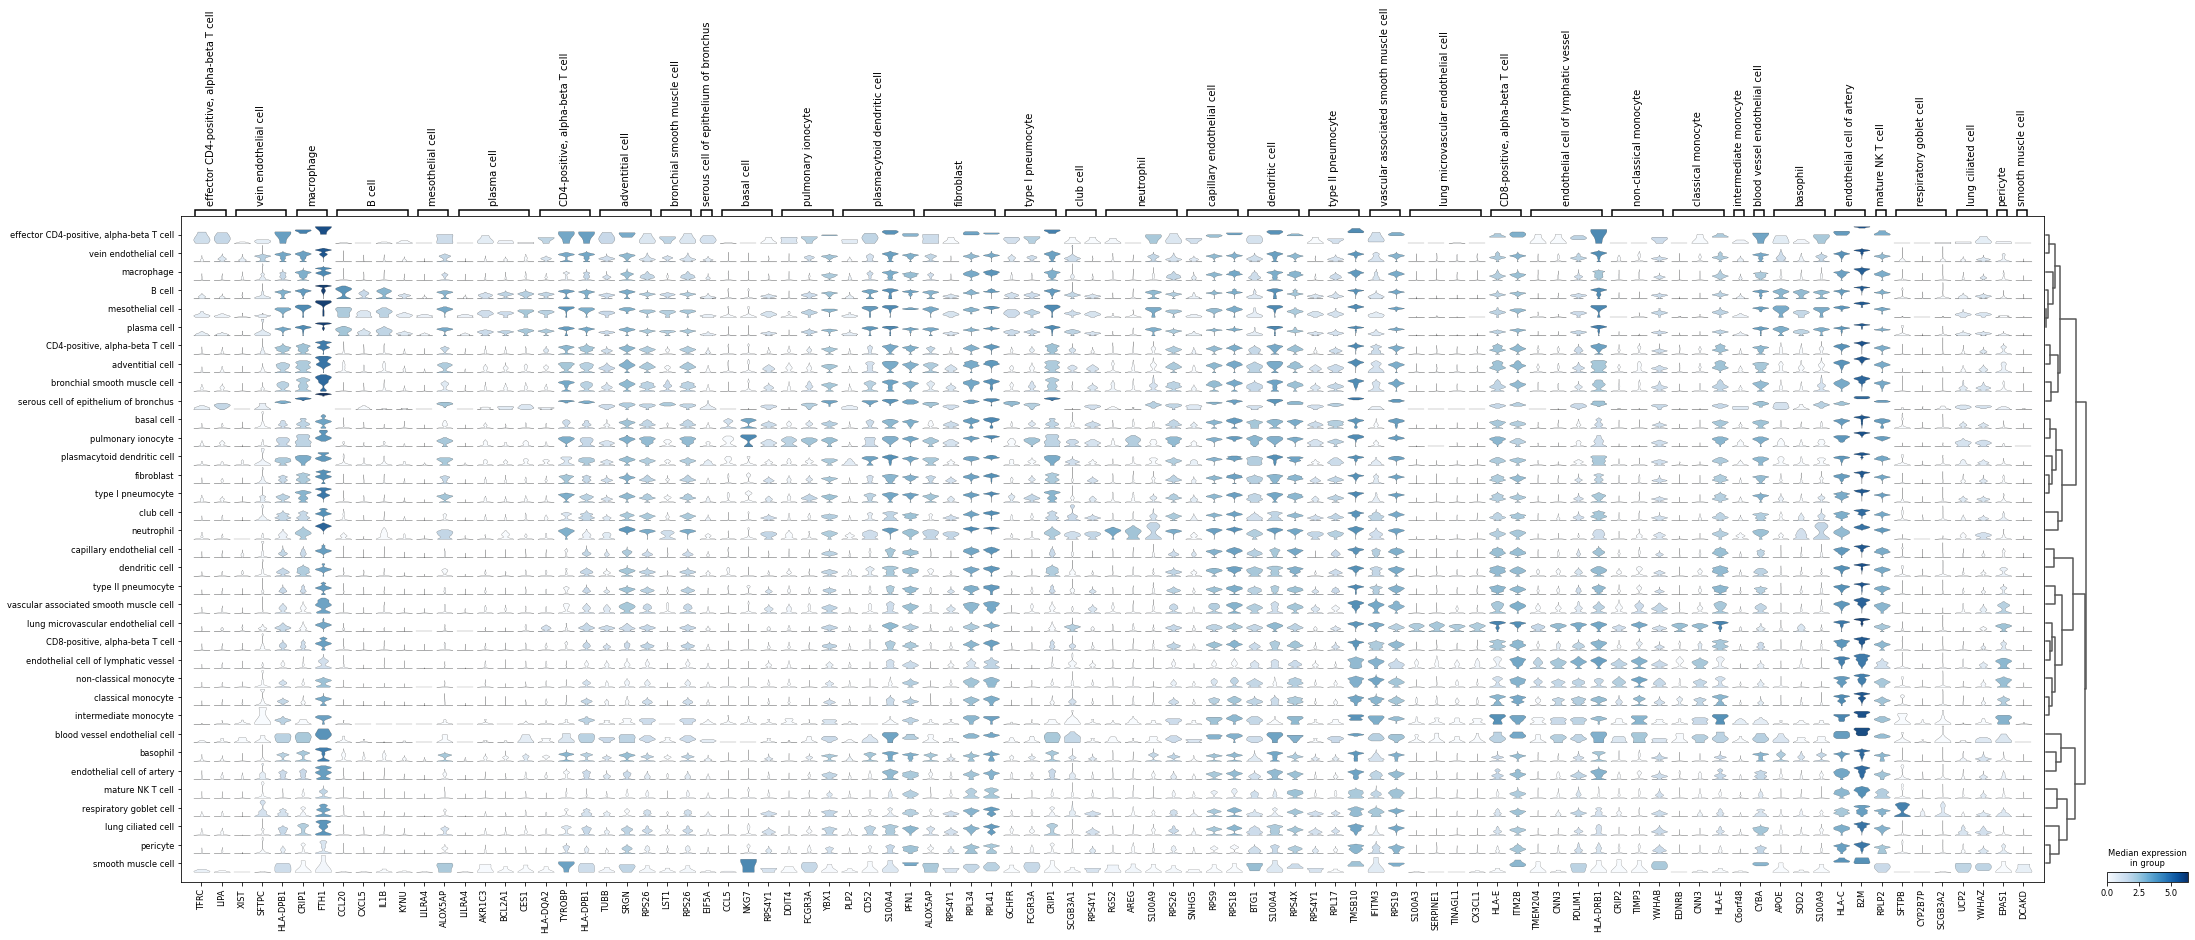

In [54]:
ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME] = dict(
    zip(
        ns_forest_markers_df['clusterName'], 
        ns_forest_markers_df['NSForest_markers']
    )
)

sc.pl.stacked_violin(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    use_raw=False
)

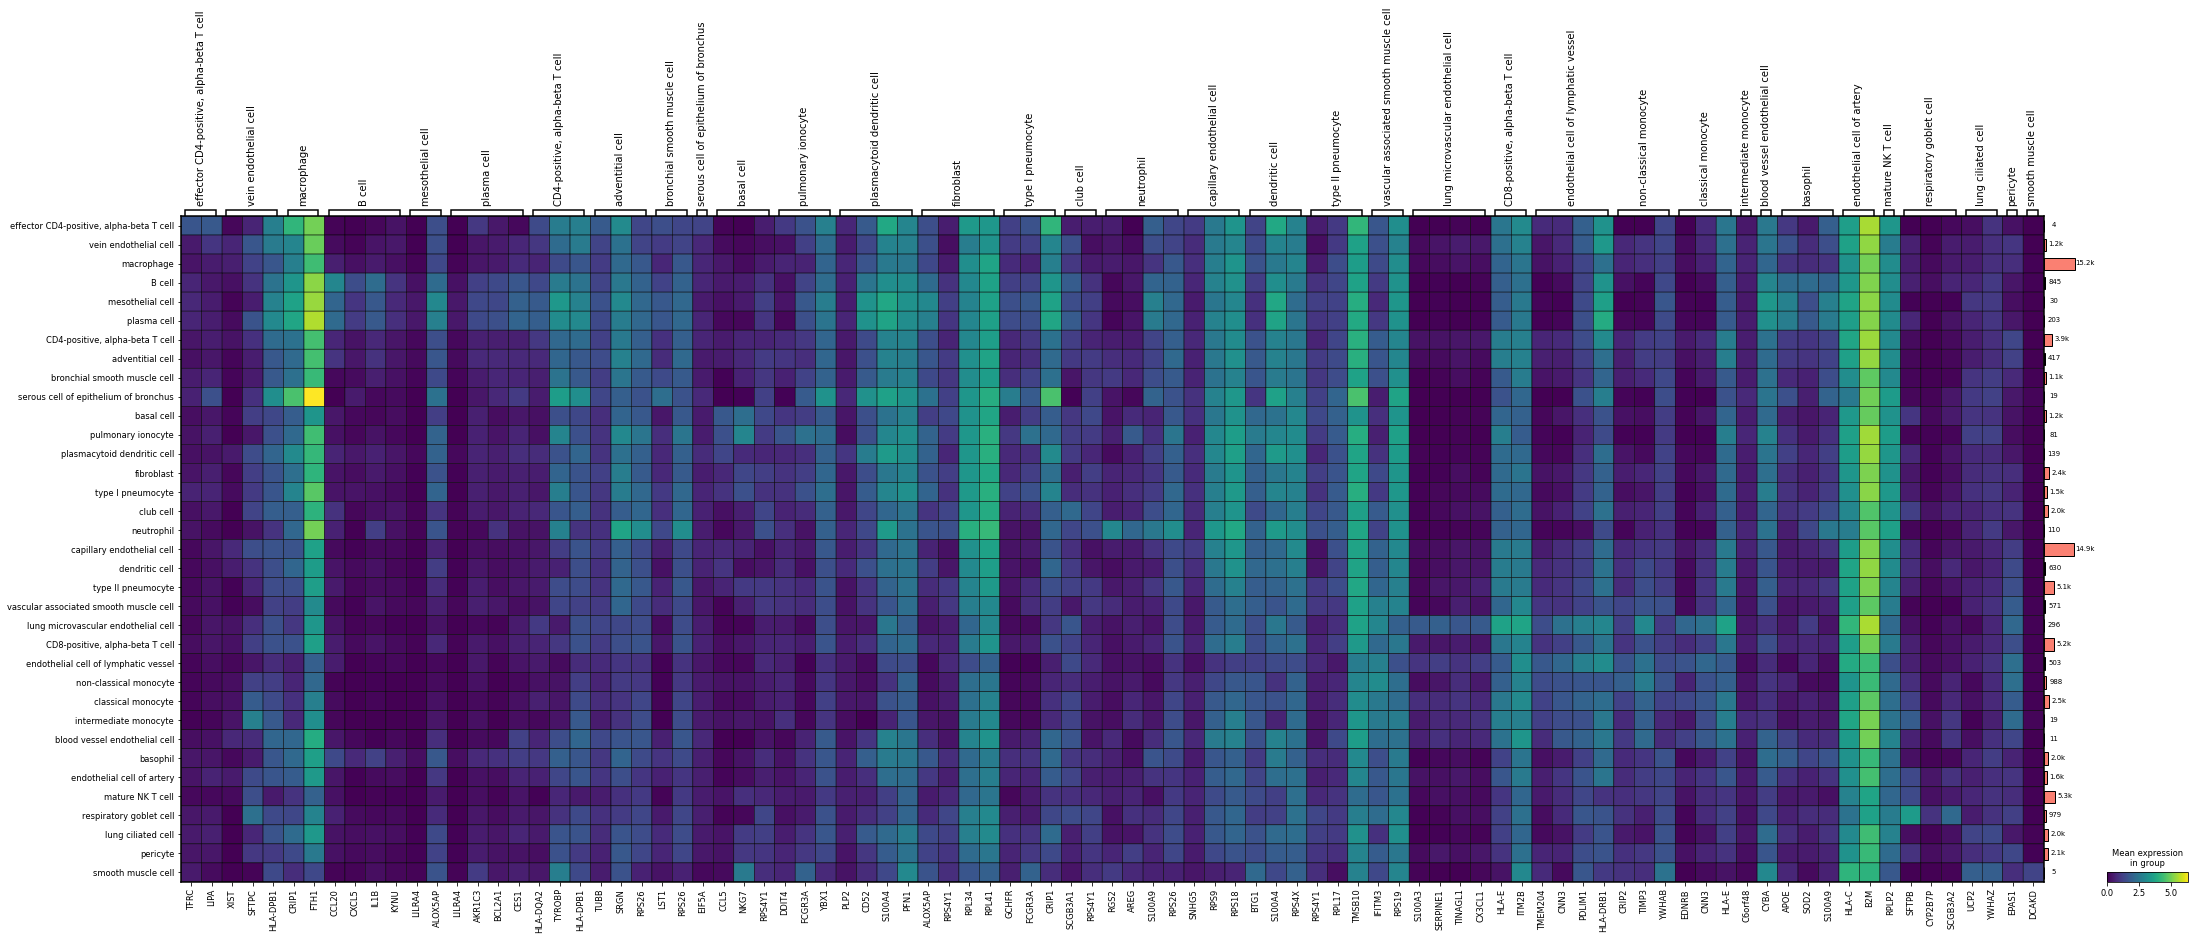

In [55]:
fig = sc.pl.matrixplot(
    predictions_adata, 
    var_names=ALGORITHMICALLY_DERIVED_MARKERS[ANNOTATION_COLUMN_NAME], 
    groupby=ANNOTATION_COLUMN_NAME, 
    dendrogram=True, 
    return_fig=True
)
fig.add_totals().style(edge_color='black', edge_lw=0.5)
fig.show()

### Merging the crosswalk information into the anndata object as well as markers identified so far.

In [56]:
from utils.asctb_util_functions import merge_asctb_crosswalk_into_derived_markers





ANNOTATION_COLNAMES = ['azimuth_preds', 'celltypist_preds', 'popv_preds']
ALGORITHMICALLY_DERIVED_MARKERS = merge_asctb_crosswalk_into_derived_markers(
    translation_hmap=translation_hmap,
    markers_dict=ALGORITHMICALLY_DERIVED_MARKERS,
    annotation_colnames=ANNOTATION_COLNAMES,
    verbose=False
)


CANONICAL_MARKERS = merge_asctb_crosswalk_into_derived_markers(
    translation_hmap=translation_hmap,
    markers_dict=CANONICAL_MARKERS,
    annotation_colnames=['azimuth'],
    verbose=False
)

# Merge the crosswalk into the AnnData.obs dataframe
for colname in ANNOTATION_COLNAMES:
    new_colname = colname + '_asctb_equivalent'
    predictions_adata.obs[new_colname] = predictions_adata.obs[colname].apply(lambda x : translation_hmap[x.lower().replace('φ','ï†')])



print(f'Markers now available for: {ALGORITHMICALLY_DERIVED_MARKERS.keys()}')
print(f'Annotation columns available in the AnnData now are: {[c for c in list(predictions_adata.obs.columns) if "preds" in c]}')
agg_crosswalk_markers_df.head()

Markers now available for: dict_keys(['azimuth_preds', 'celltypist_preds', 'popv_preds', 'azimuth_preds_asctb_equivalent', 'celltypist_preds_asctb_equivalent', 'popv_preds_asctb_equivalent'])
Annotation columns available in the AnnData now are: ['popv_preds', 'celltypist_preds', 'azimuth_preds', 'azimuth_preds_asctb_equivalent', 'celltypist_preds_asctb_equivalent', 'popv_preds_asctb_equivalent']


unique_cts  azimuth_count  popv_count  celltypist_count  \
0      adventitial cell            0.0       417.0               0.0   
1            suprabasal          580.0         0.0             860.0   
2  alveolar fibroblasts         1942.0         0.0            1847.0   
3  alveolar macrophages         9565.0         0.0            9004.0   
4    alveolar mï† ccl3+            0.0         0.0               0.0   

             asctb_equivalent  \
0             suprabasal cell   
1             suprabasal cell   
2  alveolar type 1 fibroblast   
3         alveolar macrophage   
4   alveolar macrophage ccl3+   

                                     asctb_markers  \
0                [NOTCH3, KRT19, NGFR, KRT5, TP63]   
1                [NOTCH3, KRT19, NGFR, KRT5, TP63]   
2                     [PCDH15, WNT2, TCF21, PLIN2]   
3   [CD163, MRC1, CD11c, FABP4, CD68, MARCO, CD45]   
4  [SIGLEC1, CCL3, CD206 , CD68, PTPRC/CD45, CD45]   

                                     azimuth_markers  
0                                                NaN  
1  [LDHB, KRT17, PRDX2, KRT19, SFN, S100A2, SERPI...  
2  [ADH1B, COL1A2, LUM, GPX3, C1R, MFAP4, C1S, CO...  
3  [CTSS, C1QC, ACP5, HLA-DPB1, FCER1G, COTL1, HL...  
4                                                NaN

# Create aggregated CxG per CT to identify top k Gene-expressions

# Plot the top k gene-expressions for each Cell-Type, Algorithm

> `Azimuth Preds` - 51xk plots

> `CellTypist Preds` - 34xk plots

> `PopV Preds` - 40xk plots

Suitable use-case for a [Raincloud-Plot](https://www.kaggle.com/code/carlmcbrideellis/box-strip-violin-raincloud-plot)?

todo/done:

1. Adjust x-axis labels on each figure-subaxis: gene-name not visible! - ✅

2. Add main title as `Azimuth Preds`, `CellTypist Preds`, and `PopV Preds` - ✅

3. Filter out the CT-prediction subset dataframes having <5 cells - ✅


!pip install -q ptitprince

In [57]:
# !pip install -q ptitprince

# Let's investigate agreeability per cluster between [`topK`, `bottomK`] genes (by median), [`Azimuth`/`ASCTB`] canonical genes, and [`NSForest`] derived genes.

In [ ]:
from utils.plotting import create_raincloudplot_top_k_bottom_k_genes
from utils.utiltity_functions import get_aggregated_cellbygene_matrix, get_top_and_bottom_K_genes




TOP_K = 100
BOTTOM_K = 0
AGGREGATION_METHOD = 'median'

CELLTYPE_LABELS_COLUMNS = [c for c in list(predictions_adata.obs.columns) if 'preds' in c]
MOST_EXPRESSED_GENES = {}
RAINCLOUD_PLOT_FIGURES = {}

for CELLTYPE_LABELS_COLUMN in CELLTYPE_LABELS_COLUMNS:
    print('Each data-source rainplot takes around 8mins, please be patient! Grab a coffee.')
    
    print(f'Creating aggregated cxg matrix for {CELLTYPE_LABELS_COLUMN}.')
    agg_cxg_df = get_aggregated_cellbygene_matrix(predictions_adata, celltype_labels_column=CELLTYPE_LABELS_COLUMN, aggregation_method=AGGREGATION_METHOD, verbose=False)

    print(f'Fetching top-{TOP_K} and bottom-{BOTTOM_K} genes for {CELLTYPE_LABELS_COLUMN}.')
    MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN] = get_top_and_bottom_K_genes(agg_cxg_df, celltype_labels_column=CELLTYPE_LABELS_COLUMN, top_k=TOP_K, bottom_k=BOTTOM_K, verbose=False)

    print(f'Creating raincloud plots for top-{TOP_K} and bottom-{BOTTOM_K} genes for {CELLTYPE_LABELS_COLUMN}.')
    RAINCLOUD_PLOT_FIGURES[CELLTYPE_LABELS_COLUMN] = create_raincloudplot_top_k_bottom_k_genes(
        predictions_adata,
        most_expressed_genes=MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN],
        celltype_labels_column=CELLTYPE_LABELS_COLUMN,
        aggregation_method=AGGREGATION_METHOD,
        filter_sparse_cell_types=False,
        top_k=TOP_K,
        bottom_k=BOTTOM_K,
        verbose=False
    )

Each data-source rainplot takes around 8mins, please be patient! Grab a coffee.
Creating aggregated cxg matrix for popv_preds.


# Visualizing the mean expression values for top-K Genes via a heatmap

## We'll overlay the features-selected via NSForest, with Canonical Marker-features from Azimuth/ASCTB

#### Azimuth and CellTypist Lung Naming convention is just completely different as compared to PopV and ASCTB.

Impact- even though we've parsed the ASCT+B data to fetch a key-value store of `CT -> Markers`, we can't overlay this information onto the top-K gene-medians plot.

Solution- Use the crosswalk translation table to bring the naming convention to a controlled vocabulary.

!pip install -i https://test.pypi.org/simple/ asctb-ct-label-mapper

!pip install matplotlib-venn

In [ ]:
from asctb_ct_label_mapper.utilities.plotting import make_venn_diagram

try:
    make_venn_diagram(
        A=set(predictions_adata.obs['azimuth_preds'].values), 
        B=set(predictions_adata.obs['celltypist_preds'].values), 
        C=set(predictions_adata.obs['popv_preds'].values), 
        labels=['azimuth', 'celltypist', 'popv'],
        title='Annotation labels from the 3 reference-models are disjointed sets'
    )
except Exception as e:
    print(f'Something went wrong with the Venn-diagram creation...{e}')

In [ ]:
from asctb_ct_label_mapper.utilities.plotting import make_venn_diagram

try:
    make_venn_diagram(
        A=set(predictions_adata.obs['azimuth_preds_asctb_equivalent'].values), 
        B=set(predictions_adata.obs['celltypist_preds_asctb_equivalent'].values), 
        C=set(predictions_adata.obs['popv_preds_asctb_equivalent'].values), 
        labels=['azimuth', 'celltypist', 'popv'],
        title='Crosswalked-Annotation labels from the 3 reference-models for better agreeability'
    )
except Exception as e:
    print(f'Something went wrong with the Venn-diagram creation...{e}')

### Let's overlay the ASCT+B markers onto the Top-K gene-medians for Azimuth predictions

In [ ]:
from utils.plotting import create_heatmap_top_k_bottom_k_genes



CELLTYPE_LABELS_COLUMN = 'azimuth_preds_asctb_equivalent'
fig = create_heatmap_top_k_bottom_k_genes(
    most_expressed_genes=MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN],
    canonical_markers_one=CANONICAL_MARKERS['azimuth_asctb_equivalent'],
    canonical_markers_two=CANONICAL_MARKERS['asctb'],
    derived_markers=ALGORITHMICALLY_DERIVED_MARKERS[CELLTYPE_LABELS_COLUMN],
    top_k=TOP_K,
    bottom_k=0
)

In [ ]:
CELLTYPE_LABELS_COLUMN = 'celltypist_preds_asctb_equivalent'
fig = create_heatmap_top_k_bottom_k_genes(
    most_expressed_genes=MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN],
    canonical_markers_one=CANONICAL_MARKERS['azimuth_asctb_equivalent'],
    canonical_markers_two=CANONICAL_MARKERS['asctb'],
    derived_markers=ALGORITHMICALLY_DERIVED_MARKERS[CELLTYPE_LABELS_COLUMN],
    top_k=TOP_K,
    bottom_k=0
)

> Below, the highly expressed genes for PopV's clusters (translated to ASCTB) don't show much info when overlayed with ASCTB known-markers.

In [ ]:
set(MOST_EXPRESSED_GENES['popv_preds_asctb_equivalent'].keys()) & set(CANONICAL_MARKERS['asctb'].keys()), \
    set(MOST_EXPRESSED_GENES['popv_preds_asctb_equivalent'].keys()) & set(CANONICAL_MARKERS['azimuth_asctb_equivalent'].keys())

In [ ]:
set(MOST_EXPRESSED_GENES['popv_preds_asctb_equivalent']['b cell']['index']) & set(CANONICAL_MARKERS['asctb']['b cell']),\
    set(MOST_EXPRESSED_GENES['popv_preds_asctb_equivalent']['b cell']['index']) , set(CANONICAL_MARKERS['asctb']['b cell'])

In [ ]:
CELLTYPE_LABELS_COLUMN = 'popv_preds_asctb_equivalent'
fig = create_heatmap_top_k_bottom_k_genes(
    most_expressed_genes=MOST_EXPRESSED_GENES[CELLTYPE_LABELS_COLUMN],
    canonical_markers_one=CANONICAL_MARKERS['azimuth_asctb_equivalent'],
    canonical_markers_two=CANONICAL_MARKERS['asctb'],
    derived_markers=ALGORITHMICALLY_DERIVED_MARKERS[CELLTYPE_LABELS_COLUMN],
    top_k=TOP_K,
    bottom_k=0
)